In [ ]:
import pandas as pd
import pyodbc
import statsmodels.api as sm
#from scipy import stats
#import numpy as np
import gc
import os
from woe5 import woe
from claudia import ks,gini
import pandas as pd
import pyodbc
import statsmodels.api as sm
#from scipy import stats
#import numpy as np

# Importación de la tabla en Chunks

In [ ]:
chunkTemp = []
queryTemp = []
query = pd.DataFrame()

for chunk in pd.read_csv('ori3.csv', header=0, chunksize=10000, iterator=True, low_memory=False,encoding='latin'):

    #REPLACING BLANK SPACES AT COLUMNS' NAMES FOR SQL OPTIMIZATION
    chunk = chunk.rename(columns = {c: c.replace(' ', '') for c in chunk.columns})

    #YOU CAN EITHER: 
    #1)BUFFER THE CHUNKS IN ORDER TO LOAD YOUR WHOLE DATASET 
    chunkTemp.append(chunk)

#!  NEVER DO pd.concat OR pd.DataFrame() INSIDE A LOOP
print("Database: CONCATENATING CHUNKS INTO A SINGLE DATAFRAME")
chunk = pd.concat(chunkTemp)
print("Database: LOADED")



In [ ]:
len(df)


In [ ]:
## Si usaramos SQl
#f="SELECT  * FROM bdrie.dbo.ori_base "
#sql_con = pyodbc.connect('driver={SQL Server};SERVER=OF00SRVBDH;Trusted_Connection=True;DATABASE=MIS1')
#base  = pd.read_sql(f, sql_con)

In [ ]:
chunk.columns

# Usamos filtros requeridos

In [ ]:
df = chunk[(chunk['prioridad_solicitud'] == 1) & (chunk['n_rcc'] >= 3) & (chunk['atr0_m'] <=8)]
len(df)

In [ ]:
df.id.unique()

In [ ]:
base = df[df['id']!= 2]
print(len(base))
print(base.id.unique())

# Division Entrenamiento y Test

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(base,test_size=0.3)
print(len(train))
print(len(test))

# Variables 

In [ ]:
Variable Capacidad de pago contingente

In [ ]:
w=woe([float('-Inf'),0.052934,0.150451,float('Inf')])
w.fit(train['END_capacidad_pago_contingente_corr'],train['id'])
#w.optimize(max_nodes=5,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
print(sum(w.iv))
w.plot()


Variable Numero de Decrementos de Saldo

In [ ]:
w=woe()
w.fit(train['END_NUM_DECREM_SALDO_U24M'],train['id'])
w.optimize(max_nodes=4,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
w.plot()


# Calculo masivo de WOEs

In [ ]:
cuadro=w.massive(train,'id',deploy=True,train=train,test=test)
ivs=cuadro[0]

In [ ]:
pd.options.display.max_rows = 999
View=ivs[ivs['Names'].str.contains("END_")]
View.sort_values(by='IV', ascending=False)


# Completitud

In [ ]:
#x_train.columns
lista=[]
for names in df.columns:
    lista.append([names,sum(df[names].isnull())/len(df)])
lista

In [ ]:
listaa=pd.DataFrame(lista)
listaa.columns=['Name','per_NA']

In [ ]:
listaa.sort_values(by='per_NA', ascending=False)

In [ ]:
len(x_train.columns) #Total de variables 

# Guardando con pickle

In [ ]:
import pickle
pickle.dump(cuadro, open('cuadro_ivs.pkl','wb'))
pickle.dump(train, open('ori3_train.pkl','wb'))
pickle.dump(test, open('ori3_test.pkl','wb'))

# Revisando variables Especificas

In [ ]:
cuadros=cuadro[1]

In [ ]:
##Chequeando tablas de Woes
#133 es capacidad de pago #134 es leveragetabla=cuadros[133] 
print(tabla)
print('     ')
print('El iv es: ',sum(tabla['iv']))
#print(sum(tabla['bad'])/(sum(tabla['bad'])+sum(tabla['good'])))

In [ ]:
#Reconstruyendo la variables
w=woe([float('-Inf'),0.052934,float('Inf')])
w.fit(train['END_capacidad_pago_contingente_corr'],train['id'])
#w.optimize(max_nodes=5,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
w.plot()
#train[str('END_capacidad_pago_contingente_corr'+'_binned')]=w.deploy(train)
#test[str('END_capacidad_pago_contingente_corr'+'_binned')]=w.deploy(test) 

In [ ]:
##Chequeando tablas de Woes
#133 es capacidad de pago
tabla=cuadros[134] 
print(tabla)
print('     ')
print('El iv es: ',sum(tabla['iv']))
#print(sum(tabla['bad'])/(sum(tabla['bad'])+sum(tabla['good'])))

# Agregando variables adicionales

In [ ]:
f="SELECT  * FROM bdrie.dbo.ori_base_f2 "
sql_con = pyodbc.connect('driver={SQL Server};SERVER=OF00SRVBDH;Trusted_Connection=True;DATABASE=MIS1')
chunk2  = pd.read_sql(f, sql_con)
chunk2.head()

In [ ]:
chunk2.rename(columns={'ccodsol': 'cCodSol'},inplace=True)
chunk2.columns

In [ ]:
chunk2['cCodSol']=chunk2['cCodSol'].astype(float)

In [ ]:
train=train.merge(chunk2[['cCodSol','END_PROM_PU_TC_U12M_2','END_ULTIMO_SOW_2']], how='left',on='cCodSol')
test=test.merge(chunk2[['cCodSol','END_PROM_PU_TC_U12M_2','END_ULTIMO_SOW_2']], how='left',on='cCodSol')
base=base.merge(chunk2[['cCodSol','END_PROM_PU_TC_U12M_2','END_ULTIMO_SOW_2']], how='left',on='cCodSol')
train.head()

In [ ]:
w=woe()
w.fit(train['END_ULTIMO_SOW_2'],train['id'])
w.optimize(max_nodes=2,samples=round(0.05*len(train)))
print(w.stat)
tabla_sow=w.stat
#print(w.stat)
#print(w._checkMonotonic())
#print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
#print(sum(w.stat['iv']))
w.plot()

In [ ]:
w=woe()
w.fit(train['END_PROM_PU_TC_U12M_2'],train['id'])
w.optimize(max_nodes=2,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
print(sum(w.stat['iv']))
w.plot()

In [ ]:
train[str('END_PROM_PU_TC_U12M_NA'+'_binned')]=w.deploy(train)
test[str('END_PROM_PU_TC_U12M_NA'+'_binned')]=w.deploy(test) 
base[str('END_PROM_PU_TC_U12M_NA'+'_binned')]=w.deploy(test) 


# Agregando capacidad Corregida

In [ ]:
f="SELECT  cCodSol,capacidad_pago_contingente_corr as  END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2,id FROM bdrie.dbo.ori_base_f "
sql_con = pyodbc.connect('driver={SQL Server};SERVER=OF00SRVBDH;Trusted_Connection=True;DATABASE=MIS1')
chunk3  = pd.read_sql(f, sql_con)
chunk3.head()

In [ ]:
chunk4 = chunk3[chunk3['id']!=2]

In [ ]:
w=woe()
w.fit(chunk4['END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2'],chunk4['id'])
w.optimize(max_nodes=2,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
print(sum(w.stat['iv']))
w.plot()


In [ ]:
chunk3['cCodSol']=chunk3['cCodSol'].astype(float)

In [ ]:
train.drop('END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2',axis=1,inplace=True)
test.drop('END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2',axis=1,inplace=True)
df.drop('END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2',axis=1,inplace=True)

In [ ]:
train=train.merge(chunk3[['cCodSol','END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2']], how='left',on='cCodSol')
test=test.merge(chunk3[['cCodSol','END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2']], how='left',on='cCodSol')
df=df.merge(chunk3[['cCodSol','END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2']], how='left',on='cCodSol')

In [ ]:
train['END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2'].head()

# Corrigiendo Variable

In [ ]:
w=woe([float('-Inf'),0.835406,float('Inf')])
w.fit(train['END_ULTIMO_SOW'],train['id'])
#w.optimize(max_nodes=2,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
print(sum(w.stat['iv']))
w.plot()


In [ ]:
train[str('END_ULTIMO_SOW_2'+'_binned')]=w.deploy(train)
test[str('END_ULTIMO_SOW_2'+'_binned')]=w.deploy(test) 
base[str('END_ULTIMO_SOW_2'+'_binned')]=w.deploy(test) 

# Corrigiendo Capacidad

In [ ]:
train.cCodCta.unique()

In [ ]:
train2=train[train['cCodCta']!='            ']

In [ ]:
sum(train2.cCodCta.isnull())

In [ ]:
w=woe()
w.fit(train2['END_CAPACIDAD_PAGO_CONTINGENTE_CORR_2'],train2['id'])
w.optimize(max_nodes=2,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
print(sum(w.stat['iv']))
w.plot()


# Filtrando solo columnas de interes

In [ ]:
#Renombrando
train = train.rename(columns={'capacidad_pago_contingente_corr_binned': 'END_capacidad_pago_contingente_corr_binned', 'capacidad_pago_contingente_corr': 'END_capacidad_pago_contingente_corr'})
test = test.rename(columns={'capacidad_pago_contingente_corr_binned': 'END_capacidad_pago_contingente_corr_binned', 'capacidad_pago_contingente_corr': 'END_capacidad_pago_contingente_corr'})
train = train.renam e(columns={'leverage_contingente_corr_binned': 'END_leverage_contingente_corr_binned', 'leverage_contingente_corr': 'END_leverage_contingente_corr'})
test = test.rename(columns={'leverage_contingente_corr_binned': 'END_leverage_contingente_corr_binned', 'leverage_contingente_corr': 'END_leverage_contingente_corr'})

In [ ]:
#Quedandonos solo con las columnas de interes
filter_col = [col for col in train if col.startswith('END_')]
filter_col = [col for col in filter_col if col.endswith('_binned')]
x_train = train[filter_col]
x_test = test[filter_col]
y_train = train['id']
y_test = test['id']


# Funciones Necesarias

In [ ]:
''' Backward Elimination'''

def backwardElimination(Y, X, sl,frame=False,test=False,dftest=None):
    numVars = len(X.columns)
    for i in range(0, numVars):
        X = sm.add_constant(X)
        regressor = sm.Logit(Y, X).fit()
        if frame:
            print(regressor.summary())
        maxVar = max(regressor.pvalues)#.astype(float)
        if maxVar > sl:
            for name in regressor.pvalues.index:
                if (regressor.pvalues[name].astype(float) == maxVar) and name!='const': #\
               # and name!='const':
                    X=X.drop([name],axis=1)
                    if test:
                        dftest=dftest.drop([name],axis=1)
    return X,dftest


''' Funcion para eliminar correlacion '''

def eliminate_corr(df):
    #Se pueden generar errores si una variables es no númerica
    #print(df.shape)
    corr=df.corr()
    #print(corr.shape)
    #Hacemos que por default todas las variables se incluyan (van con True)
    columns = np.full((corr.shape[0],), True, dtype=bool)
    
    #Vamos por cada fila
    for i in range(corr.shape[0]):
        #Vamos por cada columnas diferente a la variable (por eso el i+1)
        for j in range(i+1, corr.shape[0]):
            
            #Si la correlación es igual a 1 , hacemos que el campo sea False y por lo tanto no se incluya
            if abs(corr.iloc[i,j]) == 1:
                
                if columns[j]:
                    columns[j] = False
       
    selected_columns = df.columns[columns]
    return selected_columns


''' Funcion para escribir xlsx'''

def save_xls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,'sheet%s' % n)
        writer.save()



''' Funcion para eliminar correlaciones en función del IV '''

def eliminate_corr_iv(df,correla,ivs,analisis_iv=True):
    #Se pueden generar errores si una variables es no númerica
    #print(df.shape)
    corr=df.corr()
    #print(corr.shape)
    #Hacemos que por default todas las variables se incluyan (van con True)
    columns = np.full((corr.shape[0],), True, dtype=bool)
    
    #Vamos por cada fila
    for i in range(corr.shape[0]):
        #Vamos por cada columnas diferente a la variable (por eso el i+1)
        for j in range(i+1, corr.shape[0]):
            
        
           # print(i)
           # print(j)
           # print(corr.index.values)
           # print(corr.index.values[i][:-7])
           # print(corr.columns.values[j][:-7])
           # print(float(ivs[ivs['Names']==corr.index.values[i][:-7]]['IV']))
           # print(float(ivs[ivs['Names']==corr.columns.values[j][:-7]]['IV']))
            
   
            
#            print((float(ivs[ivs['Names']==corr.columns.values[j][:-7]]['IV']) < float(ivs[ivs['Names']==corr.columns.values[i][:-7]]['IV'])))
#            if abs(corr.iloc[i,j]) > 0.5:
#                True
#            else:
#                False
            
#           break
#        break
        
            #Si la correlación es igual a un corr , hacemos que el campo sea False y por lo tanto no se incluya
            #Solo s excluye si el iv de la variable en la columna es menor a lde la fila 
            if abs(corr.iloc[i,j]) > correla:
                if analisis_iv:
                    if columns[j] and (float(ivs[ivs['Names']==corr.columns.values[j][:-7]]['IV']) > float(ivs[ivs['Names']==corr.columns.values[i][:-7]]['IV'])) :
                        if columns[i]:
                            columns[i] = False 
                    elif columns[j] and (float(ivs[ivs['Names']==corr.columns.values[j][:-7]]['IV']) < float(ivs[ivs['Names']==corr.columns.values[i][:-7]]['IV'])) : 
                        if columns[j]:
                            columns[j] = False 
                    else:
                        pass
                else:
                    if columns[j]:
                        columns[j] = False 

            #break
       
    selected_columns = df.columns[columns]
    return selected_columns        


In [ ]:
cor=x_train.corr()

In [ ]:
#print(cor.columns.values[0][:-7])
#print(cor.index.values[1][:-7])
float(ivs[ivs['Names']==cor.columns.values[0][:-7]]['IV'])

In [ ]:
#####Corrigiendo un problema con nombres #####
#ivs2=ivs.copy()
#ivs2[ivs2['Names']=='capacidad_pago_contingente_corr']['Names']
#ivs2.at[133,'Names']='END_capacidad_pago_contingente_corr'
#ivs2[ivs2['Names']=='END_leverage_contingente_corr']
#ivs2.at[134,'Names']='END_leverage_contingente_corr'

# Revisando Correlación

In [ ]:
#Creando la tabla final
import numpy as np
x_trainh=x_train.copy()
x_train is x_trainh

In [ ]:
#Evitando que la matriz sea singular
final_columns = eliminate_corr(x_trainh)

In [ ]:
x_trainh=x_trainh[final_columns]
x_trainh.head()

Ninguna variables tenia una correalción de 1

In [ ]:
#Evitando que la matriz tengan variables que se correlacionan mucho entre ellas
final_columns = eliminate_corr_iv(x_train,0.60,ivs2,analisis_iv=False)
print(len(final_columns))
print(final_columns)


In [ ]:
#Evitando que la matriz tengan variables que se correlacionan mucho entre ellas
final_columns = eliminate_corr_iv(x_train,0.60,ivs2,analisis_iv=True) #Notese que se usa iv2 en vez de ivs
print(len(final_columns))
print(final_columns)


In [ ]:
x_trainh=x_train.copy()
x_trainh=x_trainh[final_columns]
x_testh=x_test.copy()
x_testh=x_testh[final_columns]

In [ ]:
x_trainh.drop(['END_capacidad_pago_contingente_corr_binned','END_MAX_INCREM_SALDO_TOTAL_U6M_binned','END_MAX_INCREM_SALDO_MICRO_U12M_binned'],axis=1,inplace=True)
x_testh.drop(['END_capacidad_pago_contingente_corr_binned','END_MAX_INCREM_SALDO_TOTAL_U6M_binned','END_MAX_INCREM_SALDO_MICRO_U12M_binned'],axis=1,inplace=True)
print(x_trainh.columns)
print(x_testh.columns)

In [ ]:
x_trainh.head()

# Cambiando variables

In [ ]:
print(len(train))
print(len(x_trainh))

In [ ]:
#x_trainh.drop(['END_ULTIMO_SOW_2_binned','END_PROM_PU_TC_U12M_NA_binned'],axis=1,inplace=True)
#x_testh.drop(['END_ULTIMO_SOW_2_binned','END_PROM_PU_TC_U12M_NA_binned'],axis=1,inplace=True)
x_trainh.drop(['END_PROM_PU_TC_U12M_binned','END_ULTIMO_SOW_binned'],axis=1,inplace=True)
x_testh.drop(['END_PROM_PU_TC_U12M_binned','END_ULTIMO_SOW_binned'],axis=1,inplace=True)
x_trainh=pd.concat([x_trainh,train[['END_ULTIMO_SOW_2_binned','END_PROM_PU_TC_U12M_NA_binned']]],axis=1)
x_testh=pd.concat([x_testh,test[['END_ULTIMO_SOW_2_binned','END_PROM_PU_TC_U12M_NA_binned']]],axis=1)
x_trainh.columns

In [ ]:
x_trainh.drop(['END_PROM_PU_TC_U12M_NA_binned'],axis=1,inplace=True)
x_testh.drop(['END_PROM_PU_TC_U12M_NA_binned'],axis=1,inplace=True)

In [ ]:
x_trainh.head()

In [ ]:
x_trainh.columns

In [ ]:
x_trainh=pd.concat([x_trainh, train['END_capacidad_pago_contingente_corr_binned']],axis=1)
x_trainh.columns

In [ ]:
x_testh=pd.concat([x_testh, test['END_capacidad_pago_contingente_corr_binned']],axis=1)
x_testh.columns

# Modelamiento

In [ ]:
x_trainh.corr()

In [ ]:
import statsmodels.api as sm

In [ ]:
#Añadiendo Constante
#x_trainh = x_train.copy()
x_trainh = sm.add_constant(x_trainh)
x_testh = sm.add_constant(x_testh)

In [ ]:
#Definiendo Respuesta
y_trainh = 1 - y_train
y_testh = 1 - y_test

In [ ]:
#Nivel de p value
SL=0.01

In [ ]:
#Backward Elimination
x_trainh,x_testh = backwardElimination(y_trainh,x_trainh,\
                                           SL,test=True,\
                                       dftest=x_testh,frame=True)


In [ ]:
x_trainh.columns

In [ ]:
x_trainh.drop('END_capacidad_pago_contingente_corr_binned',axis=1,inplace=True)
x_testh.drop('END_capacidad_pago_contingente_corr_binned',axis=1,inplace=True)

In [ ]:
#Modelo Final 1 
est = sm.Logit(y_trainh,x_trainh)
res = est.fit()
print(res.summary())

# Chequeando que las variables tengan sentido

In [ ]:
ivs[ivs['Names']=='END_PROM_PU_TC_U12M']
cuadros[13] 

¿Mejora en IV por agregar la categoría NA?

In [ ]:
ivs[ivs['Names']=='END_ULTIMO_SOW']
print(cuadros[17])
sum(cuadros[17].iv)

Agregar saldo compartamos (crear una nueva variable)
Juntar el campo 0 y el campo 1 en esta variable                       

In [ ]:
ivs[ivs['Names']=='END_DIF_ENT_TOTAL_U12M']
cuadros[28]
#sum(cuadros[28].iv)

Deberiamos trabajar con saldo compartamos actualizado
OK

In [ ]:
ivs[ivs['Names']=='END_VAR_SALDO_TOTAL_U12M']
cuadros[44] 

OK

In [ ]:
ivs[ivs['Names']=='END_ENT_SALDO_TOTAL_UM']
cuadros[56] 

OK

In [ ]:
#END_DIF_PORCEN_UTIL_LINEA_U12M
ivs[ivs['Names']=='END_DIF_PORCEN_UTIL_LINEA_U12M']
cuadros[64] 

OK

In [ ]:
ivs[ivs['Names']=='END_NUM_INCREM_SALDO_TOTAL_U9M']
cuadros[67]
#END_NUM_INCREM_SALDO_TOTAL_U9M

In [ ]:
OK

In [ ]:
ivs[ivs['Names']=='END_MAXSALDOTC_PROMLINEATC_U12M']
cuadros[76]
#END_MAXSALDOTC_PROMLINEATC_U12M

In [ ]:
OK

In [ ]:
ivs[ivs['Names']=='END_DEUACT_MAXDEU_TOTAL_U24M']
cuadros[93]

OK

In [ ]:
ivs[ivs['Names']=='END_MAX_INCREM_SALDO_TOTAL_U6M']
cuadros[114]

In [ ]:
ivs[ivs['Names']=='END_MAX_INCREM_SALDO_MICRO_U12M']
cuadros[117]

In [ ]:
ivs[ivs['Names']=='END_NUM_DECREM_SALDO_U24M']
cuadros[120]

OK

In [ ]:
ivs[ivs['Names']=='capacidad_pago_contingente_corr']
cuadros[133]


# KS Gini

In [ ]:
print(x_trainh.shape)
print(x_testh.shape)

In [ ]:
y_pred_test=res.predict(x_testh)
y_pred_train=res.predict(x_trainh)

In [ ]:
print('-----------------------------------------------Train--------------------------------------')
print(gini(y_trainh,y_pred_train,plot=True)) # Train
print(ks(y_trainh,y_pred_train)) #Train
print('-----------------------------------------------Test---------------------------------------')
print(gini(y_testh,y_pred_test,plot=True)) # Test
print(ks(y_testh,y_pred_test)) #Test

In [ ]:
0.3074  0.22
0.3139  0.22

# Score Card

In [ ]:
scoreCard=pd.concat([cuadros[28],cuadros[44],cuadros[56],cuadros[64],cuadros[67],cuadros[76],cuadros[93],cuadros[120],tabla_sow],axis=0)

In [ ]:
scoreCard

In [ ]:
len(x_train.columns)

# Exportando a Excel

In [ ]:
from pandas import ExcelWriter
results_summary = res.summary()
results_as_html = results_summary.tables[1].as_html()
results=pd.read_html(results_as_html, header=0, index_col=0)[0]
    
save_xls([scoreCard,results],'final1.xlsx')

In [ ]:
x_trainh.columns

# Puntaje 

In [ ]:
import math

In [ ]:
len(df)

In [ ]:
df.id.unique()

In [ ]:
tabla_sow

In [ ]:
tabla_sow['z']='END_ULTIMO_SOW'
tabla_sow

In [ ]:
m= woe()
#Deploy en frames

#[cuadros[28],cuadros[44],cuadros[56],cuadros[64],cuadros[67],cuadros[76],cuadros[93],cuadros[120],tabla_sow]


df['END_DIF_ENT_TOTAL_U12M_binned']=m.deploy_frame(cuadros[28],df)
df['END_VAR_SALDO_TOTAL_U12M_binned']=m.deploy_frame(cuadros[44],df)
df['END_ENT_SALDO_TOTAL_UM_binned']=m.deploy_frame(cuadros[56],df)
df['END_DIF_PORCEN_UTIL_LINEA_U12M_binned']=m.deploy_frame(cuadros[64],df)
df['END_NUM_INCREM_SALDO_TOTAL_U9M_binned']=m.deploy_frame(cuadros[67],df)
df['END_MAXSALDOTC_PROMLINEATC_U12M_binned']=m.deploy_frame(cuadros[76],df)
df['END_DEUACT_MAXDEU_TOTAL_U24M_binned']=m.deploy_frame(cuadros[93],df)
df['END_NUM_DECREM_SALDO_U24M_binned']=m.deploy_frame(cuadros[120],df)
df['END_ULTIMO_SOW_2_binned']=m.deploy_frame(tabla_sow,df)

In [ ]:
df.columns

In [ ]:
#Puntaje 
df['puntaje']= (res.params[0]+ \
df['END_DIF_ENT_TOTAL_U12M_binned']*res.params[1]+ \
df['END_VAR_SALDO_TOTAL_U12M_binned']*res.params[2]+\
df['END_ENT_SALDO_TOTAL_UM_binned']*res.params[3]+\
df['END_DIF_PORCEN_UTIL_LINEA_U12M_binned']*res.params[4]+\
df['END_NUM_INCREM_SALDO_TOTAL_U9M_binned']*res.params[5]+\
df['END_MAXSALDOTC_PROMLINEATC_U12M_binned']*res.params[6]+\
df['END_DEUACT_MAXDEU_TOTAL_U24M_binned']*res.params[7]+\
df['END_NUM_DECREM_SALDO_U24M_binned']*res.params[8]+\
df['END_ULTIMO_SOW_2_binned']*res.params[9])*80/math.log(2)+ 600

# Agregando Mora de Cosechas 

In [ ]:
f="SELECT cCodSol,ncapdes,nsalven FROM bdrie.dbo.ori_base_f2 "
sql_con = pyodbc.connect('driver={SQL Server};SERVER=OF00SRVBDH;Trusted_Connection=True;DATABASE=MIS1')
chunk2  = pd.read_sql(f, sql_con)

In [ ]:
chunk2['cCodSol']=chunk2['cCodSol'].astype(float)

In [ ]:
df=df.merge(chunk2[['cCodSol','ncapdes','nsalven']], how='left',on='cCodSol')

df.head()

# Segmentación de Score

In [ ]:
#col_names = {'count_nonzero': 'tasamalos', 'size': 'obs'}
df['bucket'] = pd.qcut(df['puntaje'], 20 ,\
         duplicates='drop',retbins=True)[0]

In [ ]:
df['mora6']=df['nsalven']/df['ncapdes']

In [ ]:
analisis=df[['bucket','id','mora6','cCodSol']]

# Probando con clientes con al menos un RCC

In [ ]:
df.id.unique()

In [ ]:
len(df)

In [ ]:
df2 = df[(df['END_ENT_SALDO_TOTAL_UM']>0) & (df['id']!=2)]

In [ ]:
print(len(df2))
print(len(x_trainh)+len(x_testh))

In [ ]:
df2['id2'] = 1 - df2['id']

In [ ]:
print('--------------------------------------------Al menos un RCC--------------------------------------')
print(gini(df2['id2'],df2['puntaje'],plot=True))
print(ks(df2['id2'],df2['puntaje'])) 


# Probando con clientes que hayan desembolsado

In [ ]:
df3=df2[df2['ncapdes']>0]

In [ ]:
print('--------------------------------------------Desembolsado--------------------------------------')
print(gini(df3['id2'],df3['puntaje'],plot=True))
print(ks(df3['id2'],df3['puntaje'])) 

# Nuevo modelo con al menos una entidad

In [ ]:
#Filtramos
base_g = df2[df2['id']!= 2]
print(len(base_g))
print(base_g.id.unique())

#Dividimos en Train y Test
from sklearn.model_selection import train_test_split
train_g,test_g=train_test_split(base_g,test_size=0.3)
print(len(train_g))
print(len(test_g))


In [ ]:
train_g= train_g[['END_DIF_ENT_TOTAL_U12M',
       'END_VAR_SALDO_TOTAL_U12M', 'END_ENT_SALDO_TOTAL_UM',
       'END_DIF_PORCEN_UTIL_LINEA_U12M',
       'END_NUM_INCREM_SALDO_TOTAL_U9M',
       'END_MAXSALDOTC_PROMLINEATC_U12M',
       'END_DEUACT_MAXDEU_TOTAL_U24M',
       'END_NUM_DECREM_SALDO_U24M', 'END_ULTIMO_SOW','id']]

test_g= test_g[['END_DIF_ENT_TOTAL_U12M',
       'END_VAR_SALDO_TOTAL_U12M', 'END_ENT_SALDO_TOTAL_UM',
       'END_DIF_PORCEN_UTIL_LINEA_U12M',
       'END_NUM_INCREM_SALDO_TOTAL_U9M',
       'END_MAXSALDOTC_PROMLINEATC_U12M',
       'END_DEUACT_MAXDEU_TOTAL_U24M',
       'END_NUM_DECREM_SALDO_U24M', 'END_ULTIMO_SOW','id']]


In [ ]:
import woe5 as woe

In [ ]:
%%time
w=woe()
grid=w.massive(train_g,'id',deploy=True,train=train_g,test=test_g)
#Agregar al deplot df2

In [ ]:
w=woe()
grid=w.massive(train_g,'id')

In [ ]:
grid[0].sort_values(by='IV', ascending=False)

In [ ]:
grid[0].sort_values(by='IV', ascending=False)

In [ ]:
#Quedandonos solo con las columnas de interes
filter_col2 = [col for col in train_g if col.startswith('END_')]
filter_col2 = [col for col in filter_col2 if col.endswith('_binned')]
x_traing = train_g[filter_col2]
x_testg = test_g[filter_col2]
y_traing = train_g['id']
y_testg = test_g['id']

In [ ]:
#Previas al modelo
x_traing = sm.add_constant(x_traing)
x_testg = sm.add_constant(x_testg)

y_traing = 1 - y_traing
y_testg = 1 - y_testg


In [ ]:
import statsmodels.api as sm
estg = sm.Logit(y_traing,x_traing)
resg = estg.fit()
print(resg.summary())

In [ ]:
resg.summary()

In [ ]:
#KS Gini

y_pred_testg=resg.predict(x_testg)
y_pred_traing=resg.predict(x_traing)

print('----------------------------------------Train con al menos 1 Entidad--------------------------------------')
print(gini(y_traing,y_pred_traing,plot=True)) # Train
print(ks(y_traing,y_pred_traing)) #Train
print('-----------------------------------------Test con al menos 1 Entidad -------------------------------------')
print(gini(y_testg,y_pred_testg,plot=True)) # Test
print(ks(y_testg,y_pred_testg)) #Test




In [ ]:
######################################################Score Card###################################
card2=pd.DataFrame()
for cuadro in grid[1]:
    card2=pd.concat([card2,cuadro],axis=0)
    

In [ ]:
#Añadiendo coeficientes
results_summary = resg.summary()
results_as_html = results_summary.tables[1].as_html()
results=pd.read_html(results_as_html, header=0, index_col=0)[0]
results=results.reset_index()
results['index'] = results['index'].map(lambda x: x.rstrip('_binned'))
results=results.set_index('index')
card2=card2.set_index('z')
card2=card2.join(results['coef'])
card2.reset_index()

In [ ]:
#Añadiendo puntajes
import math
a_sumar=(resg.params[0]*80/math.log(2))/(len(resg.params)-1)
card2['puntaje']=round(card2['coef']*card2['woe']*100)
card2['puntaje_ajustado'] = round(card2['coef']*card2['woe']*80/math.log(2)+a_sumar)

In [ ]:
card2[['breaks','puntaje_ajustado']]

In [ ]:
#Exportando
from pandas import ExcelWriter

save_xls([card2,results],'finalfinal.xlsx')

In [ ]:
#Guardando con pickle
import pickle
#pickle.dump(cuadro, open('cuadro_ivs.pkl','wb'))
#pickle.dump(train, open('ori3_train.pkl','wb'))
#pickle.dump(test, open('ori3_test.pkl','wb'))
pickle.dump(ivs, open('ivs.pkl','wb'))
pickle.dump(x_train, open('x_train.pkl','wb'))
pickle.dump(y_train, open('y_train.pkl','wb'))
pickle.dump(x_test, open('x_test.pkl','wb'))
pickle.dump(y_test, open('y_test.pkl','wb'))
pickle.dump(df, open('df.pkl','wb'))
pickle.dump(df2, open('df2.pkl','wb'))
pickle.dump(train_g, open('train_g.pkl','wb'))
pickle.dump(test_g, open('test_g.pkl','wb'))
pickle.dump(base_g, open('base_g.pkl','wb'))
pickle.dump(x_traing, open('x_traing.pkl','wb'))
pickle.dump(x_testg, open('x_testg.pkl','wb'))
pickle.dump(y_traing, open('y_traing.pkl','wb'))
pickle.dump(y_testg, open('y_testg.pkl','wb'))
pickle.dump(y_pred_traing, open('y_pred_traing.pkl','wb'))
pickle.dump(y_pred_testg, open('y_pred_testg.pkl','wb'))
pickle.dump(card2, open('card2.pkl','wb'))
pickle.dump(results, open('results.pkl','wb'))
#card2 =  pickle.load(open('card2.pkl', 'rb'))
pickle.dump(dff, open('dff.pkl','wb'))
pickle.dump(resg, open('resg.pkl','wb'))

In [ ]:
import pickle
#card2
#cuadro_ivs
#df
#ivs
#x_testg
#x_traing
#y_testg
#y_traing
card2 =  pickle.load(open('card2.pkl', 'rb'))
cuadro_ivs =  pickle.load(open('cuadro_ivs.pkl', 'rb'))
df =  pickle.load(open('df.pkl', 'rb'))
ivs =  pickle.load(open('ivs.pkl', 'rb'))
x_testg =  pickle.load(open('x_testg.pkl', 'rb'))
x_traing =  pickle.load(open('x_traing.pkl', 'rb'))
y_testg =  pickle.load(open('y_testg.pkl', 'rb'))
y_traing =  pickle.load(open('y_traing.pkl', 'rb'))
df2 =  pickle.load(open('df2.pkl', 'rb'))
train_g =  pickle.load(open('train_g.pkl', 'rb'))
test_g =  pickle.load(open('test_g.pkl', 'rb'))


In [ ]:
dff =  pickle.load(open('dff.pkl', 'rb'))

In [ ]:
#Graficos
for cuadro in grid[1]:
    cuadro.plot(x='breaks',y='mean',kind='bar',title=cuadro['z'][0])


In [ ]:
#Poniendo nuevos binned
m=woe()

dff = df[df['END_ENT_SALDO_TOTAL_UM']>0]

#dff = df[(df['END_ENT_SALDO_TOTAL_UM']>0) & (df['cTipCre']!='R') & (df['ncapdes']>0)]

for cuadro in grid[1]:
    #print(cuadro)
    try:
        dff[cuadro['z'][0]+'_binned_g']=m.deploy_frame(cuadro,dff)
    except:
        print('Error')


In [ ]:
columns=pd.DataFrame(dff.columns)
columns

In [ ]:
#Puntaje 
import math
dff['puntaje_g']= (resg.params[0]+ \
dff['END_DIF_ENT_TOTAL_U12M_binned_g']*resg.params[1]+ \
dff['END_VAR_SALDO_TOTAL_U12M_binned_g']*resg.params[2]+\
dff['END_ENT_SALDO_TOTAL_UM_binned_g']*resg.params[3]+\
dff['END_DIF_PORCEN_UTIL_LINEA_U12M_binned_g']*resg.params[4]+\
dff['END_NUM_INCREM_SALDO_TOTAL_U9M_binned_g']*resg.params[5]+\
dff['END_MAXSALDOTC_PROMLINEATC_U12M_binned_g']*resg.params[6]+\
dff['END_DEUACT_MAXDEU_TOTAL_U24M_binned_g']*resg.params[7]+\
dff['END_NUM_DECREM_SALDO_U24M_binned_g']*resg.params[8]+\
dff['END_ULTIMO_SOW_binned_g']*resg.params[9])*80/math.log(2)+ 600

dff.puntaje_g.head()


In [ ]:
dff.id.value_counts()

In [ ]:
dff.columns

In [ ]:
#Exportando para creacion de segmentos
import numpy as np
col_names = {'count_nonzero': 'tasamalos', 'size': 'obs'}
dff['bucket'] = pd.qcut(dff['puntaje_g'], 20 ,\
         duplicates='drop',retbins=True)[0]

seg=dff[dff['id']!=2].groupby('bucket')['id']\
.agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names)

#seg['total']=analisis1.groupby('bucket').apply(lambda x: x[x['id'] != 2]['id'].sum())

seg['total']=dff.groupby('bucket')['id'].agg([np.size])

seg=pd.concat([seg,dff.groupby('bucket')\
               [['nsalven','ncapdes']]\
               .agg(["sum"])],axis=1)
    
seg

In [ ]:

gc.collect()

# Pivot Table 

In [ ]:
from pivottablejs import pivot_ui

In [ ]:
pivot_ui(seg)

# Segmentando Score Originacion

In [ ]:
dff['score_originacion'] = np.select(
    [
        dff['puntaje_g'].between(0, 700.173, inclusive=False), 
        dff['puntaje_g'].between(700.173, 755.244, inclusive=True),
        dff['puntaje_g'].between(755.244,802.142, inclusive=True),
        dff['puntaje_g'].between(802.142, 853.561,inclusive=True),
        dff['puntaje_g'].between(853.561,9999, inclusive=True)
    ], 
    [
        'MuyAlto', 
        'Alto',
        'Medio',
        'Bajo',
        'MuyBajo'
    ], 
    default='Error'
)

In [ ]:
gc.collect()

# Cruce Score Seguimiento

In [ ]:
f="select   cCodSol,score_seguimiento from bdrie.dbo.ori3_scoresegui "
sql_con = pyodbc.connect('driver={SQL Server};SERVER=OF00SRVBDH;Trusted_Connection=True;DATABASE=BDRIE')
chunk_segui  = pd.read_sql(f, sql_con)

In [ ]:
chunk_segui.head()

In [ ]:
#chunk_segui['score_seguimiento'].unique()
sum(chunk_segui['score_seguimiento'].isnull())

In [ ]:
len(chunk_segui)

In [ ]:
len(dff)

In [ ]:
chunk_segui['score_seguimiento'].value_counts()

In [ ]:
chunk_segui['cCodSol']=chunk_segui['cCodSol'].astype(float)

In [ ]:
dff=dff.merge(chunk_segui,how='left',on='cCodSol')

In [ ]:
#dff=dff.drop(['score_seguimiento'],axis=1)

In [ ]:
dff.columns

In [ ]:
len(dff[dff['cTipCre']=='R'])

In [ ]:
dff['score_seguimiento'].value_counts()

In [ ]:
dff['score_originacion'].value_counts()

In [ ]:
len(dff)

In [ ]:
#analisis=dff.groupby(['dfecrep','producto','cTipCre','score_originacion','score_seguimiento']).agg([np.size])['cCodSol']
dff['score_seguimiento'] = dff['score_seguimiento'].astype(str) #Debido  a que hay NULL
analisis=dff.groupby(['dfecrep','producto','cTipCre','score_originacion','score_seguimiento']).agg([np.size])['cCodSol']
#sum(analisis['size'])
analisis2=dff.groupby(['dfecrep','producto','cTipCre','score_originacion','score_seguimiento']).agg([np.sum])[['nsalven','ncapdes']]
analisis=analisis.join(analisis2,how='left')
analisis=analisis.reset_index()
save_xls([analisis],'comparacionscore.xlsx')

In [ ]:
len(dff[(dff['score_seguimiento')&(dff['cTipCre']=='R')&]=='None']['cCodSol'])

In [ ]:
max(dff['dFecSol'])

In [ ]:
dff.groupby(['score_seguimiento'])['cCodSol'].agg(['count'])

In [ ]:
dff.id.unique()

Exportacion

In [ ]:
dff[['cCodSol','cCodCta','cCodCli','score_originacion','score_seguimiento','nsalven','ncapdes']].to_csv('exportacion.csv')

In [ ]:
#Cleaning All
import sys
sys.modules[__name__].__dict__.clear()

# Deep Learning (Benchmark)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

In [21]:
import pickle
x_train =  pickle.load(open('x_train.pkl', 'rb'))
y_train =  pickle.load(open('y_train.pkl', 'rb'))
x_test =  pickle.load(open('x_test.pkl', 'rb'))
y_test =  pickle.load(open('y_test.pkl', 'rb'))

In [ ]:
import pandas as pd
#################################################Balancing Data#########################################
dff=pd.concat([x_train,y_train],axis=1)


from sklearn.utils import resample

# Separate majority and minority classes
df_majority = dff[dff.id==0]
df_minority = dff[dff.id==1]

#len(df_majority)
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.id.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64


In [ ]:
y_traind=df_upsampled['id']
x_traind=df_upsampled.iloc[:,0 : df_upsampled.shape[1]-1]
x_traind.columns

In [ ]:
print(x_traind.shape)

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(200, input_dim=x_traind.shape[1]))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(200))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(200))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(200))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(200))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(200))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(200))    
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


In [ ]:
#model.fit(x_traind, y_traind, epochs=10,batch_size=36)
from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
#keras_model.fit(x_traind, y_traind, epochs=10, batch_size=36, verbose=1)
history = keras_model.fit(x_traind, y_traind, epochs=10, batch_size=18, verbose=2)
#history = keras_model.fit(x_traind, y_traind, validation_split=0.33, epochs=10, batch_size=18, verbose=0)
# list all data in history


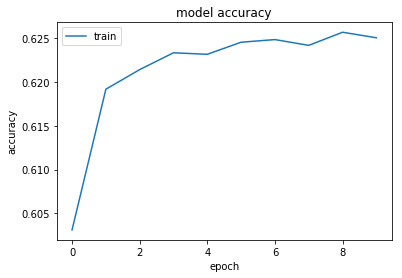

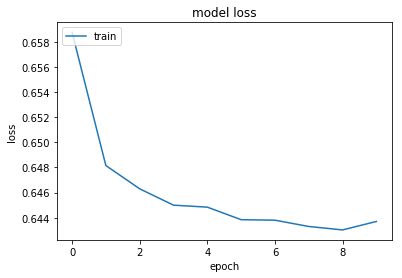

In [18]:
import matplotlib.pyplot as plt
#print(history.history.keys())

plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               13200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_3 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
__________

In [42]:
score = keras_model.evaluate(x_test, y_test)
score[1]

54201/54201 [==============================] - 10s 178us/step


0.5851183557410964

In [43]:
#from sklearn.metrics import roc_curve
#y_pred_keras = model.predict(y_test).ravel()
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [44]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC :',auc_keras)
print('Gini :',auc_keras*2-1)

AUC : 0.677272288127009
Gini : 0.35454457625401803


In [26]:
import statsmodels.api as sm
#from sklearn.linear_model import LogisticRegresssion
# Supervised transformation based on random forests
#rf = LogisticRegresssion()
#rf.fit(x_train, y_train)
rf = sm.Logit(y_traind,x_traind)
rf = rf.fit()
#print(rf.summary())

print(x_traind.shape)
sm.add_constant(x_test)
print(x_test.shape)
y_pred_rf = rf.predict(x_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
#print(x_train.columns)
#print(x_test.columns)


Optimization terminated successfully.
         Current function value: 0.644854
         Iterations 5
(208800, 65)
(54201, 65)


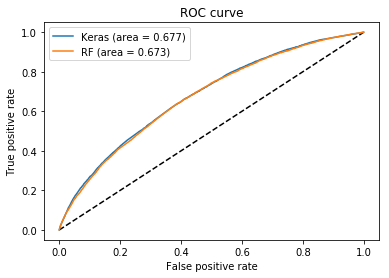

In [45]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



# XgBoost

In [31]:
import xgboost as xgb

In [36]:
data_dmatrix = xgb.DMatrix(data=x_traind,label=y_traind)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [77]:
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)

In [79]:
xg_reg.fit(x_traind,y_traind)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [80]:
preds = xg_reg.predict(x_test)

In [81]:
from sklearn.metrics import roc_curve
fpr_boost, tpr_boost, thresholds_boost = roc_curve(y_test, preds)
auc_boost = auc(fpr_boost, tpr_boost)
print('AUC :',auc_boost)
print('Gini :',auc_boost*2-1)

AUC : 0.6751678108574061
Gini : 0.35033562171481214


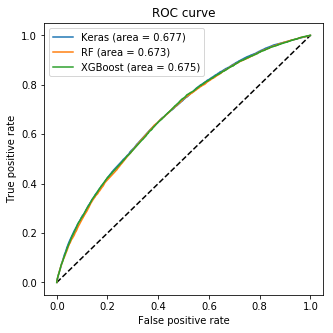

In [85]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_boost, tpr_boost, label='XGBoost (area = {:.3f})'.format(auc_boost))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


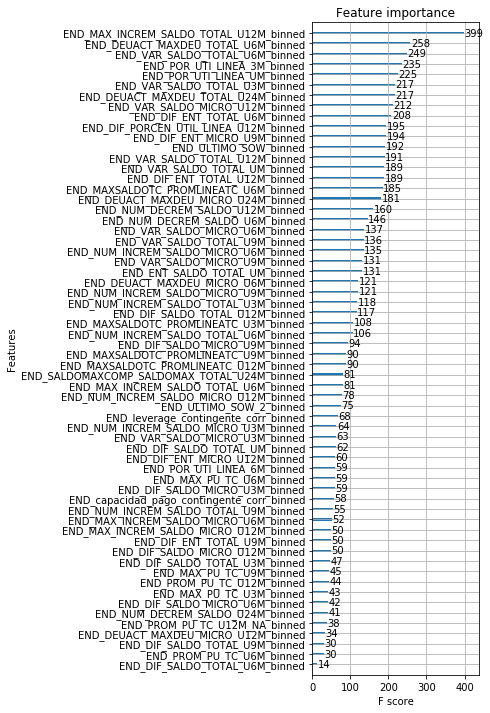

In [92]:
#import matplotlib.pyplot as plt

#xgb.plot_tree(xg_reg,num_trees=0)
#plt.rcParams['figure.figsize'] = [50, 10]
#plt.show()

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [3, 15]
plt.show()